# Time Propagation of a Wave Function

$$
\newcommand{\op}[1]{\mathbf{#1}}
$$
For the scattering problems we were looking at in class, our previous methods for solving the Schrödinger equations are not ideal. You *can* do scattering problems that way, essentially in a large infinite square well, to which you add the scattering barrier. The problem that arrises is that the solutions are not very accurate and become less so as you get further away from $t=0$.

There is a different way we can think about the problem. We can solve, numerically, the time dependent Schrödinger equation, and then use this to evolve our initial wave function in time. This method is nicely implemented by Jake VanderPlas, see here: https://jakevdp.github.io/blog/2012/09/05/quantum-python

Let's start with the full equation:
$$
i\hbar\frac{\partial \Psi}{\partial t} = \op H \Psi 
$$
If you didn't know that $\op{H}$ represented an operator, but instead treated it as a number, then the solution would be relatively easily found by integration. It turns out you can do this with an operator just the same, so the solution is then:
$$
\Psi(x,t+\Delta t) = e^{-i\op{H}\Delta t/\hbar} \Psi(x,t)
$$
Or the "time evolution operator" is given by:
$$
\op{U(\Delta t)} = e^{-i\op{H}\Delta t/\hbar}
$$
The exponent of an operator can be treated uses an infinite series, so:
$$
e^{-i\op{H}\Delta t/\hbar} = \sum_n \frac{ (-i\op{H}\Delta t/\hbar)^n}{n!}
$$
If you try to evaluate this numerically, you will find that it very quickly diverges from the correct answer, for any appreciable size for $\Delta t$, so for *numerical* evaluation you must have, $\Delta t < 2/\lambda_{max}$, where $\lambda_{max}$ is the largest Energy level of the Hamiltonian. The reason is subtle and rather complicated, and can be found in [Numerical Recipes 3d edition 17.5 in the library](https://eds.a.ebscohost.com/eds/detail/detail?vid=1&sid=8847ad4b-021b-4fed-9228-f0c67a34c6b6%40sessionmgr4010&bdata=JnNpdGU9ZWRzLWxpdmU%3d#AN=unh.b2802390&db=cat00099a) [or 2nd edition online, page 735](https://www2.units.it/ipl/students_area/imm2/files/Numerical_Recipes.pdf). If you take a $\Delta t$ that is larger, then he errors in the calculation pile up so quickly that this approach is not practical if we try to evaluate it directly this way. We also note that this is *not* a fast way to evaluate a time step, since the matrix multiplication is of order $N^2$ in operations.

## Setup the Hamiltonian
We setup the Hamiltonian like we did before in the notebook "Solving the Schrödinger Equation Numerically". One difference is that we need to be a bit more careful here about our x-space. We want to make sure the x-space has exactly $N$ steps in it, so that we go from $x_0$ up to $x_N$ in exactly $N$ steps. This is most easily done by creating a range $n$ that goes from 0 to $N$, and then letting $x_n = x_0 + n \Delta x$, with 
$\Delta x = (x_N - x_0)/N$. This means we get arrays with $N$ values, but never *quite* get to $x_N$. 

For the sake of faster FFTs, later on, we set $N$ to be a power of 2.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.fftpack as fft
# Input parameters.
hbar=1
m=1
N = 2**12   # FFT is a lot faster on domains which are powers of 2.
a = 400.0
step_low = 0.
step_high= 1.
V0 = 10.
# Define the space:
n = np.arange(N)
x0 = -a/2.
xN = a/2.
Delta_x = (xN - x0)/N
print "Delta_x = ",Delta_x
x = x0 + n*Delta_x  # This creates the correct array of x values.
###################################################
# Potential Definition.
###################################################
V=np.zeros(N)
for i in range(N):
    if x[i]>= step_low and x[i]<= step_high:
        V[i]= V0
###################################################
# Setup the Hamiltonian for function V
#
Mdd = 1./(Delta_x**2)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
En,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]

Delta_x =  0.09765625


### Set the timestep

We need to be careful about how big the step is that we take in time. What we learn from Numerical Recipes is that we need to stay below $\Delta t = 2/\lambda_{max}$, where the $\lambda_i$ are the eigen values of the matrix, in our case $\op H$. This is easy to calculate since we already found the eigen values. 

In [2]:
dt_max = 2/np.max(En) # Stability Criteria
dt= 0.001
if dt>dt_max:
    print "WARNING: dt is in the instable region!!!!!"

## Define the initial wave function to propagate.

In [3]:
g_x0=-10.
g_k0=6.
g_sig=2.

# Gaussian in k-space, where p = \hbar k, with a momentum k0, and x-space psi(x,0) (2a/pi)^1/4 e^{-ax^2}
def psi0(x,g_x0,g_k0,g_sig):
    _Norm_x=np.sqrt(Delta_x/g_sig)/(np.pi**0.25)
    return(_Norm_x*np.exp(-(x-g_x0)**2/(2.*g_sig*g_sig)+1j*g_k0*x))

psi_t0 = psi0(x,g_x0,g_k0,g_sig)

#def phi(k,g_k0,g_x0,g_sig):
#    _Norm_k=np.sqrt(g_sig*Delta_k)/(np.pi**0.25)
#    return(_Norm_k*np.exp(-0.5*g_sig*g_sig*(k-g_k0)**2-1j*g_x0*(k-g_k0)))

# Direct Evaluation of the Exponential
If we try to evaluate the equation 
$$
e^{-i\op{H}\Delta t/\hbar} = \sum_n \frac{ (-i\op{H}\Delta t/\hbar)^n}{n!}
$$
directly. Taking into account the condition for the stability of the differential equation (see 17.5.20 in Numerical Recipes 3rd edition).

First, let us do a basic test to make sure our Hamiltonian is actually Hermetian:

In [4]:
print "Check if H is actually Hermetian! ",np.array_equal(H.conj().T,H) # Is H Hermetian?

Check if H is actually Hermetian!  True


In [5]:
Ut_mat = np.diag(np.ones(N,dtype="complex128"),0)
print "Creating a U(dt={}) Matrix".format(dt)
for n in range(1,3):  # Do the summation. Since this is matrixes, this takes a little while if N is large.
    Ut_mat += np.linalg.matrix_power((-1j*dt*H/hbar),n)/math.factorial(n)

Creating a U(dt=0.001) Matrix


In [6]:
p=Ut_mat.dot(psi_t0)
print "How much is the normalization changing per step? From {} to {}".format(np.linalg.norm(psi_t0),np.linalg.norm(p))
print "Number of steps at which point norm is off by a factor of 2: ",1/(np.linalg.norm(p)-1)

How much is the normalization changing per step? From 1.0 to 1.00000001278
Number of steps at which point norm is off by a factor of 2:  78238636.6062


In [7]:
Ut_mat_dagger = Ut_mat.conj().T
print "If the U(t) matrix properly unitary? ",np.array_equal(Ut_mat_dagger,Ut_mat)
print "Didn't think so, or else the norm would not change!"
print "This should be the Identity matrix, but the diagonal terms are not 1!!"
print np.diag(Ut_mat.dot(Ut_mat_dagger))[0:5]


If the U(t) matrix properly unitary?  False
Didn't think so, or else the norm would not change!
This should be the Identity matrix, but the diagonal terms are not 1!!
[ 1.00007934+0.j  1.00013034+0.j  1.00013223+0.j  1.00013223+0.j
  1.00013223+0.j]


We can now try to evaluate the movement of the gaussian by repeatedly applying $U(\Delta t)$. Since $\Delta t$ is small, it takes a fair number of steps. The speed is SLOW, because each step evaluates at an order $N^2$ speed, where the FFT algorithms performs at $N\log N$.

In [8]:
psi_t0 = psi0(x,g_x0,g_k0,g_sig)
psi_t1 = psi_t0
psi_tu = []
for t in range(3500):
    psi_t1 = Ut_mat.dot(psi_t1)
    if t>0 and t%500==0:
        psi_tu.append( (t,psi_t1))
psi_tu.append( (t,psi_t1))

We need to test that our results make sense. We check the normalization for each step, the expectation value of the energy $<E>$, and the expectation value of the position $<x>$. The posistion is expected to increase by $p$ times $t$, until it hits the barrier where the wave splits up.

In [9]:
print "Normalization: ",np.linalg.norm(psi_tu[-1][1])
vev_E0=float(np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0))))
vev_x0=float(np.real(np.sum(np.conjugate(psi_t0)*x*psi_t0)))
print "<E_(t=0)> = {:8.4f}  <x_(t=0)>= {:8.4f}".format(vev_E0,vev_x0)

for t,p in psi_tu:
    norm = np.linalg.norm(p)
    vev_E1=float(np.real(np.sum(np.conjugate(p)*H.dot(p))))
    vev_x1=float(np.real(np.sum(np.conjugate(p)*x*p)))
    print "dt={:7.1f}  norm = {:8.5f}  <E> = {:8.4f}  <x_(dt)>= {:8.4g}".format(t,norm,vev_E1,vev_x1)

Normalization:  1.00004473636
<E_(t=0)> =  17.5429  <x_(t=0)>= -10.0000
dt=  500.0  norm =  1.00001  <E> =  17.5432  <x_(dt)>=   -7.164
dt= 1000.0  norm =  1.00001  <E> =  17.5434  <x_(dt)>=   -4.335
dt= 1500.0  norm =  1.00002  <E> =  17.5436  <x_(dt)>=    -1.55
dt= 2000.0  norm =  1.00003  <E> =  17.5439  <x_(dt)>=   0.8044
dt= 2500.0  norm =  1.00003  <E> =  17.5441  <x_(dt)>=     2.91
dt= 3000.0  norm =  1.00004  <E> =  17.5443  <x_(dt)>=    5.103
dt= 3499.0  norm =  1.00004  <E> =  17.5446  <x_(dt)>=    7.305


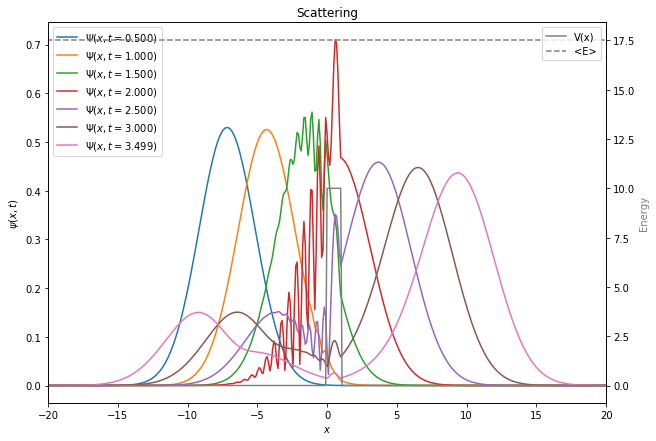

In [10]:
fig,ax1 = plt.subplots(figsize=[10,7])
if vev_E0>max(V):
    plt.title('Scattering')
else:
    plt.title('Tunneling')
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
#ax1.plot(x,np.abs(psi_t0)/np.sqrt(Delta_x),label="$\Psi(x,t=0)$")
for t,p in psi_tu:
    ax1.plot(x,np.abs(p)/np.sqrt(Delta_x),label="$\Psi(x,t={:6.3f})$".format(t*dt))
ax1.legend(loc='upper left')
ax2=ax1.twinx()
ax2.plot(x,V,color="grey",label="V(x)")
ax2.plot([x[0],x[N-1]],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
ax2.set_ylabel("Energy",color="grey")
ax2.set_xlim(g_x0-5*g_sig,-g_x0+5*g_sig)
ax2.legend(loc='upper right')
#plt.savefig("Displaced_state.pdf")
plt.show()

## Pre-compute 0.5 s steps. 
One advantange of the direct computation of the exponent is that we can pre-compute a 0.5 step by taking the product of $0.5/\Delta_t$ matrixes. There is a routine to do this in one step. This step will be slow, but subsequent ones will be fast.

In [11]:
%time Ut_05s = np.linalg.matrix_power(Ut_mat,int(0.5/dt) )

CPU times: user 3min 26s, sys: 9.74 s, total: 3min 36s
Wall time: 54.6 s


We now do all the previous steps once more, but they go faster.

In [12]:
psi_t0 = psi0(x,g_x0,g_k0,g_sig)
psi_t1 = psi_t0
psi_tu05 = []
for t in range(7):
    psi_t1 = Ut_05s.dot(psi_t1)
    psi_tu05.append( (t,psi_t1))
# psi_tu.append( (t,psi_t1))
print "Start"
for t,p in psi_tu05:
    norm = np.linalg.norm(p)
    vev_E1=float(np.real(np.sum(np.conjugate(p)*H.dot(p))))
    vev_x1=float(np.real(np.sum(np.conjugate(p)*x*p)))
    print "dt={:7.1f}  norm = {:8.5f}  <E> = {:8.4f}  <x_(dt)>= {:8.4g}".format(t,norm,vev_E1,vev_x1)



Start
dt=    0.0  norm =  1.00001  <E> =  17.5432  <x_(dt)>=    -7.17
dt=    1.0  norm =  1.00001  <E> =  17.5434  <x_(dt)>=    -4.34
dt=    2.0  norm =  1.00002  <E> =  17.5436  <x_(dt)>=   -1.555
dt=    3.0  norm =  1.00003  <E> =  17.5439  <x_(dt)>=   0.8002
dt=    4.0  norm =  1.00003  <E> =  17.5441  <x_(dt)>=    2.905
dt=    5.0  norm =  1.00004  <E> =  17.5443  <x_(dt)>=    5.099
dt=    6.0  norm =  1.00004  <E> =  17.5446  <x_(dt)>=    7.305


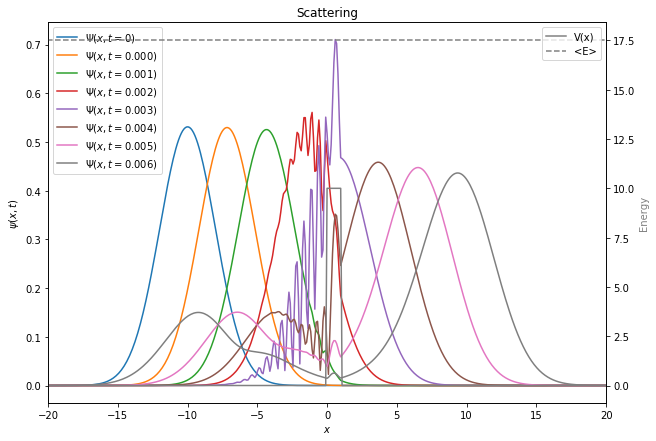

In [13]:
fig = plt.figure(figsize=[10,7])
if vev_E0>max(V):
    plt.title('Scattering')
else:
    plt.title('Tunneling')
ax1 = fig.add_subplot(111)
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
line, = ax1.plot(x,np.abs(psi_t0)/np.sqrt(Delta_x),label="$\Psi(x,t=0)$")
for t,p in psi_tu05:
    ax1.plot(x,np.abs(p)/np.sqrt(Delta_x),label="$\Psi(x,t={:6.3f})$".format(t*dt))
ax1.legend(loc='upper left')
ax2=ax1.twinx()
ax2.plot(x,V,color="grey",label="V(x)")
ax2.plot([x[0],x[N-1]],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
ax2.set_ylabel("Energy",color="grey")
ax2.set_xlim(g_x0-5*g_sig,-g_x0+5*g_sig)
ax2.legend(loc='upper right')
#plt.savefig("Displaced_state.pdf")
plt.show()

# Split time - momentum evaluation
Instead of evaluating it directly, we can split the operator in two. Since $\op H = -\frac{\hbar^2}{2m} \op p^2 + V(x)$, you can see that we can rewrite the time evolution operator as:
$$
\op{U(t)} = e^{-i\op{H}t/\hbar} = e^{i\frac{\hbar}{2m}\op p^2 t} e^{-iV(x)t/\hbar}
$$
The exponent with the potential does not contain derivatives, to it is relatively easy to evaluate numerically. On the discetized $x$-coordinate, $x_i$, we get for each $i$ in the space:
$$
\Psi(x_n,t+\Delta t) = \Psi(x_n,t) e^{-iV(x_i)\Delta t/\hbar}
$$
The momentum term is trickier on the $x$-basis, since it involves derivatives. Trying to evaluate them directly leads to the instability of directly evaluating $U(t)$. An interesting idea is that evaluating this part of $U(t)$ in *momentum space* is much easier, since now we do not have a derivative any longer. You get:
$$
\widetilde \Psi(p,t+\Delta t) = \widetilde \Psi(p,t) e^{i\hbar p^2\Delta t/(2m)}
$$
This idea is interesting because we can switch from $\Psi$ to $\widetilde \Psi$ relatively quickly using Fast Fourier Transforms (FFT). We do need to be careful with the constants of the FFT, see below.

We can then describe the algorithm as:
* Take a half step in $x$: $\Psi_n = \Psi_n \exp(-iV(x_i)\Delta t/2\hbar)$
* FFT to compute $\widetilde \Psi$ from $\Psi$
* Take a full step in $p$: $\widetilde \Psi_m = \widetilde \Psi_m \exp(i\hbar p^2\Delta t/(2m))$
* Take the inverse FFT of $\widetilde \Psi$ to recover $\Psi$.
* Take the final half step in $x$.



# Fourier Transforms

The transformation between the $x$-basis and the $p$-basis is done with the integrals:
$$
\begin{array}{lcl}
\widetilde \Psi(p,t) &=& \frac{1}{\sqrt{2\pi\hbar}} \int_{-\infty}^\infty \Psi(x,t) e^{-ipx/\hbar} dx  \\
\Psi(x,t) &=& \frac{1}{\sqrt{2\pi\hbar}}\int_{-\infty}^\infty \widetilde\Psi(p,t) e^{ipx/\hbar} dp 
\end{array}
$$
For a numerical evaluation we need to discretize these, i.e. go from continuous $x$ to $x_i$ with discrete steps, and we will need to limit the domain to $[x_0,x_N]$ instead of minus to plus infinity. The array of $x$ values would thus go from the lowest point on the x-axis, $x_0$, to the highest point, $x_N$, in $N$ steps, with a stepsize $\Delta x$, with $\Delta x = (x_N-x_0)/N$, and $x_n = x_0 + n\Delta x$. Note however that the very last point, $x_N$, is skipped, since we start at $n=0$. That detail is minor enough to not worry about it. 

Using this, the discrete version of our first integral then becomes:
$$
\widetilde \Psi(p_l,t) = \frac{1}{\sqrt{2\pi\hbar}} \sum_{n=0}^{N-1} \Psi(x_n,t) e^{-ip_l x_n/\hbar} \Delta x
$$

The [Numpy FFT algorithm](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.fft.html) executes a fast version of the sum:
$$
\widetilde F_l = \sum_{n=0}^{N-1} F_n e^{-i 2\pi n l /N}
$$
and the Inverse FFT as:
$$
 F_n = \frac{1}{N}\sum_{l=0}^{N-1}\widetilde F_l e^{i 2\pi n l /N}
$$
Note the asymmetric normalization, which is often used with FFTs. 

To get this to be the equivalent of what we want, we need to adopt the spacing of our momentum space array so that $k = p_l/\hbar = 2\pi l/(N\Delta x)$, we will call this $k$-space, which will range from $-\pi/\Delta x$ to $+\pi/\Delta x$, with a stepsize $\Delta k = 2\pi/(N\Delta x)$, so $k_l= k_0+ l\Delta k = -\pi/\Delta x + 2\pi l/(N\Delta x)$. Two things to note. With the change from $p$ to $k$, we pick up a factor of $\hbar$ when we change $dp$ to $\hbar dk$. This factor can be distributed over the two constants, so $1/\sqrt{2\pi \hbar}$ goes to $1/\sqrt{2\pi}$. Also, we do not get every $k$ out to inifinity; we cut off the very high momentum (corresponding to high frequency in $x$) terms of the wave function. This is exactly what you expect from the Nyquist sampling theorem.

The exponent term, when letting $p_l/\hbar = k\rightarrow k_0 + 2\pi l/(N\Delta x)$ and $x_n\rightarrow x_0 + n\Delta x$, then becomes:

$$
\begin{array}{lcl}
-ip_l x_n/\hbar  &\rightarrow& -i[ (k_0 + 2\pi l/(N \Delta x)) (x_0+ n\Delta x)] \\
&=& -ik_0 x_0 - i2\pi l x_0/(N\Delta x) + i k_0 n\Delta x -i 2 \pi l n/N  \\
&=& -i k_0( x_0 +n\Delta x) - i l\Delta k a - i 2\pi l n/N \\
&=& -ik_0x_n -il\Delta k x_0 - i 2\pi l n/N
\end{array}
$$

The last term is the one we want. So then, when we take the FFT, we need to set 
$$
F_n = \frac{\Delta x}{\sqrt{2\pi}}\Psi(x_n,t)e^{-ik_0 x_n}
$$
The FFT is then: 
$$
\sum_{n=0}^{N-1} \left[\frac{\Delta x}{\sqrt{2\pi}}\Psi(x_n,t)e^{-ik_0 x_n}\right] e^{-i 2\pi n l /N} = \widetilde \Psi(k,t)e^{im\Delta k x_0}
$$
and the inverse FFT is:
$$
\frac{1}{N}\sum_{l=0}^{N-1} \left[\widetilde \Psi(k,t)e^{il\Delta k x_0} \right] e^{-i 2\pi n l /N} = \frac{\Delta x}{\sqrt{2\pi}}\Psi(x_n,t)e^{-ik_0 x_n} 
$$
Now since the $\frac{\Delta x}{\sqrt{2\pi}}$ appears in the first equation, and is then taken out again in the second, and since we do not care about the normalization of $\widetilde \Psi(k,t)$, we can ignore that factor.

# The FFT based Algorithm

We will implement the algorithm for the $\op U(t)$ operator as a function, which will take $\Delta t$ and $\Psi(x,t)$ as arguments and return $\Psi(x,t+\Delta t)$. It will get every other bit of information, $V(x)$, $m,\hbar$, etc, from the global variables. This is *not* the best design from a programmer's perspective. If you wanted to use $\op U(t)$ in a real program you would probably want to turn it into a class, which stores all the needed variables and has a number of methods to manipulate the inner workings. Doing all that is better, but also obscures the calculation, so we keep things really simple here.

We now need a $k$ space as well as an $x$ space. We define it below.

In [22]:
n = np.arange(N)
k0 = -np.pi/Delta_x
kN =  np.pi/Delta_x
Delta_k = (kN-k0)/N
k = k0 + n*Delta_k 

g_x0=-10.
g_k0=6.
g_sig=2.

# Gaussian in k-space, where p = \hbar k, with a momentum k0, and x-space psi(x,0) (2a/pi)^1/4 e^{-ax^2}
def psi0(x,g_x0,g_k0,g_sig):
    _Norm_x=np.sqrt(Delta_x/g_sig)/(np.pi**0.25)
    return(_Norm_x*np.exp(-(x-g_x0)**2/(2.*g_sig*g_sig)+1j*g_k0*x))

psi_t0 = psi0(x,g_x0,g_k0,g_sig)

In [23]:
def Psi_Evolve(dt,psi0):
    '''This function will evolve the wave function by an amount dt and return the new wave function.'''
    #psi_scaled = Delta_x/np.sqrt(2*np.pi) *psi0* np.exp(-1j *k0*x)
    psi_scaled = psi0* np.exp(-1j *k0*x)
    # Take the 1/2 step in x-space with psi_scaled
    psi_scaled *= np.exp(-1j*0.5*V*dt/hbar)
    phi_scaled = fft.fft(psi_scaled)
    # Take the step in k-space
    phi_scaled *= np.exp(-1j*hbar**3*k**2*dt/(2*m))
    psi_scaled = fft.ifft(phi_scaled)
    # Take the 1/2 step in x-space with psi_scaled
    psi_scaled *= np.exp(-1j*0.5*V*dt/hbar)
    #psi_out = psi_scaled*np.sqrt(2*np.pi)/Delta_x * np.exp(+1j *k0*x)
    psi_out = psi_scaled* np.exp(+1j *k0*x)
    return(psi_out)

If we want to take $N$ steps of $\Delta t$, then for the center steps we can combine two half steps into one. We thus get the method to evolve the wave function by $N*\Delta t$:

In [24]:
def Psi_Evolve_N(dt,psi0,N):
    '''This function will evolve the wave function by an amount N*dt and return the new wave function.'''
    psi_scaled = psi0* np.exp(-1j *k0*x)
    # Take the 1/2 step in x-space with psi_scaled
    psi_scaled *= np.exp(-1j*0.5*V*dt/hbar)
    
    for i in range(N-1):     # We now take N-1 times a step in k, and then a step in x.
        phi_scaled = fft.fft(psi_scaled)
        # Take the step in k-space
        phi_scaled *= np.exp(-1j*hbar**3*k**2*dt/(2*m))
        psi_scaled = fft.ifft(phi_scaled)
        psi_scaled *= np.exp(-1j*V*dt/hbar)
 
    phi_scaled = fft.fft(psi_scaled)
    # Take the last step in k-space
    phi_scaled *= np.exp(-1j*hbar**3*k**2*dt/(2*m))
    psi_scaled = fft.ifft(phi_scaled)
    # Take the last 1/2 step in x-space with psi_scaled
    psi_scaled *= np.exp(-1j*0.5*V*dt/hbar)
    #psi_out = psi_scaled*np.sqrt(2*np.pi)/Delta_x * np.exp(+1j *k0*x)
    psi_out = psi_scaled* np.exp(+1j *k0*x)
    return(psi_out)

We can now take an initial state, a gaussian, and propagate it in time by steps of $\Delta t$. Since that step is very small, we only want a keep a few of the results to plot. We save every $500 \Delta t = 0.5$ seconds. We put these resulting wave functions in an array for plotting and testing.

In [25]:
psi_t0 = psi0(x,g_x0,g_k0,g_sig)
psi_t1 = psi_t0
psi_t = []
for i in range(7):
    t=i*500*dt
    psi_t1 = Psi_Evolve_N(dt,psi_t1,500)
#    for m in range(500):
#        psi_t1 = Psi_Evolve(dt,psi_t1)
    psi_t.append( (t,psi_t1))

We need to test that our results make sense. We check the normalization for each step, the expectation value of the energy $<E>$, and the expectation value of the position $<x>$. The posistion is expected to increase by $p$ times $t$, until it hits the barrier where the wave splits up.

In [26]:
print "Normalization: ",np.linalg.norm(psi_t[-1][1])
vev_E0=float(np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0))))
vev_x0=float(np.real(np.sum(np.conjugate(psi_t0)*x*psi_t0)))
print "<E_(t=0)> = {:8.4f}  <x_(t=0)>= {:8.4f}".format(vev_E0,vev_x0)

for t,p in psi_t:
    norm = np.linalg.norm(p)
    vev_E1=float(np.real(np.sum(np.conjugate(p)*H.dot(p))))
    vev_x1=float(np.real(np.sum(np.conjugate(p)*x*p)))
    print "t={:5.2f}  norm = {:8.5f}  <E> = {:8.4f}  <x_(dt)>= {:8.4g}".format(t,norm,vev_E1,vev_x1)

Normalization:  1.0
<E_(t=0)> =  17.5429  <x_(t=0)>= -10.0000
t= 0.00  norm =  1.00000  <E> =  17.5429  <x_(dt)>=       -7
t= 0.50  norm =  1.00000  <E> =  17.5443  <x_(dt)>=   -4.001
t= 1.00  norm =  1.00000  <E> =  17.6316  <x_(dt)>=   -1.084
t= 1.50  norm =  1.00000  <E> =  17.6528  <x_(dt)>=    1.321
t= 2.00  norm =  1.00000  <E> =  17.5533  <x_(dt)>=    3.605
t= 2.50  norm =  1.00000  <E> =  17.5436  <x_(dt)>=    5.961
t= 3.00  norm =  1.00000  <E> =  17.5430  <x_(dt)>=    8.322


Now plot the resulting waves.

In [27]:
print N

4096


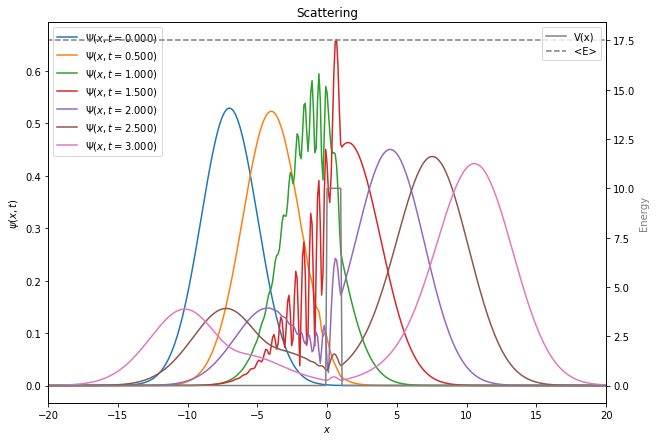

In [28]:
fig,ax1 = plt.subplots(figsize=[10,7])
if vev_E0>max(V):
    plt.title('Scattering')
else:
    plt.title('Tunneling')
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
#ax1.plot(x,np.abs(psi_t0)/np.sqrt(Delta_x),label="$\Psi(x,t=0)$")
for t,p in psi_t:
    ax1.plot(x,np.abs(p)/np.sqrt(Delta_x),label="$\Psi(x,t={:6.3f})$".format(t))
ax1.legend(loc='upper left')
ax2=ax1.twinx()
ax2.plot(x,V,color="grey",label="V(x)")
ax2.plot([x[0],x[N-1]],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
ax2.set_ylabel("Energy",color="grey")
ax2.set_xlim(g_x0-5*g_sig,-g_x0+5*g_sig)
ax2.legend(loc='upper right')
#plt.savefig("Displaced_state.pdf")
plt.show()

# Make a Movie
Calculate a movie. In most situations the FFT method is faster. If you had a relatively small $N$ for your grid, and did many pre-computed large steps in $t$, perhaps a pre-computed step would win. It all depends on what you are doing on which method would be best. Below is the FFT method, with the pre-compute method commented out.

The frame rate is set to 20 frames/second, but we slow time down by a factor 2 to make the movie more clear.

In [29]:
import matplotlib.animation as animation
from IPython.display import HTML

frame_rate = 20     # Frame rate in Hz. Make higher for smoother movie, but it takes longer to compute.
time_slowdown = 2   # Run time x times slower than normal. we want this about 10.
T=7.                # Total time to animate.
x_min = -30.
x_max = +30.

#%time Ut_1f = np.linalg.matrix_power(Ut_mat,int(1./frame_rate/dt) )  # Moves the wave by one frame according to frame rate
print int(1./frame_rate/dt)

psi_t0 = psi0(x,g_x0,g_k0,g_sig)
psi_t1 = psi_t0

fig = plt.figure(figsize=[10,7])
if vev_E0>max(V):
    plt.title('Scattering')
else:
    plt.title('Tunneling')
ax1 = fig.add_subplot(111)
ax1.grid()
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
ax1.set_xlim(x_min,x_max)
ax1.set_ylim(-0.1,0.9)
line, = ax1.plot([],[],lw=2,color='red')

time_template = 'time = {:9.2f}s'
time_text = ax1.text(0.05, 0.73, '', transform=ax1.transAxes)


def init():
    ax2=ax1.twinx()
    ax2.plot(x,V,color="grey",label="V(x)")
    ax2.plot([x[0],x[N-1]],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
    ax2.set_ylabel("Energy",color="grey")
    ax2.legend(loc='upper right')
    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(-0.1,0.9)
    line.set_data([], [])
    time_text.set_text(time_template.format(0.))
    return line, time_text

def animate(t):
    global psi_t1
    #psi_t1 = Ut_1f.dot(psi_t1)
    psi_t1 = Psi_Evolve_N(dt,psi_t1,int(1./frame_rate/dt))
    line.set_data(x,np.abs(psi_t1/np.sqrt(Delta_x)))
    time_text.set_text(time_template.format(t))
    return line,  time_text

ani = animation.FuncAnimation(fig, animate, np.linspace(0.,T,int(T*frame_rate)),
                              interval=time_slowdown*1000./frame_rate, blit=True, init_func=init)
HTML(ani.to_html5_video())

50
